In [ ]:
!mkdir data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import metrics

import warnings
warnings.filterwarnings(action = 'ignore')

In [ ]:
df_train = pd.read_csv('data/train.csv')

In [ ]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df_train['pickup_datetime'] = pd.to_datetime(
    df_train['pickup_datetime'],
    format = '%Y-%m-%d %H:%M:%S'
)
df_train['dropoff_datetime'] = pd.to_datetime(
    df_train['dropoff_datetime'],
    format = '%Y-%m-%d %H:%M:%S'
)

print(df_train['pickup_datetime'].min())
print(df_train['pickup_datetime'].max())

2016-01-01 00:00:17
2016-06-30 23:59:39


In [ ]:
df_train.isnull().sum()

,0
id,0
vendor_id,0
pickup_datetime,0
dropoff_datetime,0
passenger_count,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
store_and_fwd_flag,0


In [ ]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    return df
df_train = add_datetime_features(df_train)

In [ ]:
def get_manhattan_distance(lat1, lng1, lat2, lng2):
    # Радиус Земли в километрах
    EARTH_RADIUS = 6371

    # Переводим широты и долготы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))

    # Вычисляем разницу по широте (в радианах)
    lat_diff = lat2 - lat1
    # Вычисляем разницу по долготе (в радианах)
    lng_diff = lng2 - lng1

    # Манхэттенское расстояние по широте
    lat_distance = EARTH_RADIUS * np.abs(lat_diff)

    # Манхэттенское расстояние по долготе с учетом изменения длины параллели
    lng_distance = EARTH_RADIUS * np.abs(lng_diff) * np.cos(lat1)

    # Общая сумма — это Манхэттенское расстояние
    manhattan_distance = lat_distance + lng_distance

    return manhattan_distance

In [ ]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [ ]:
def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

In [ ]:
def add_geographical_features(df):
    df['haversine_distance'] = get_haversine_distance(
        lat1 = df['pickup_latitude'],
        lng1 = df['pickup_longitude'],
        lat2 = df['dropoff_latitude'],
        lng2 = df['dropoff_longitude']
    )
    df['direction'] = get_angle_direction(
        lat1 = df['pickup_latitude'],
        lng1 = df['pickup_longitude'],
        lat2 = df['dropoff_latitude'],
        lng2 = df['dropoff_longitude']
    )
    df['manhattan_distance'] = get_manhattan_distance(
        lat1 = df['pickup_latitude'],
        lng1 = df['pickup_longitude'],
        lat2 = df['dropoff_latitude'],
        lng2 = df['dropoff_longitude']
    )
    return df

In [ ]:
df_train = add_geographical_features(df_train)
print(
    'Медианное манхэттенское расстояние:',
    round(df_train['manhattan_distance'].median(), 2),
    'км'
)

Медианное манхэттенское расстояние: 2.69 км


In [ ]:
coords = np.hstack((df_train[['pickup_latitude', 'pickup_longitude']],
                    df_train[['dropoff_latitude', 'dropoff_longitude']]))
kmeans = cluster.KMeans(n_clusters=10, random_state=40)
kmeans.fit(coords)

KMeans(n_clusters=10, random_state=40)

In [ ]:
def add_cluster_features(df, cluster):
    df['geo_cluster'] = cluster.predict(df[[
        'pickup_latitude',
        'pickup_longitude',
        'dropoff_latitude',
        'dropoff_longitude'
    ]])
    return df
df_train = add_cluster_features(df_train, kmeans)
df_train['geo_cluster'].value_counts().sort_values(ascending = False)

,count
geo_cluster,
7,600565
0,389121
3,367514
5,52484
4,27010
8,14859
2,7077
9,6
6,6


Изучим данные на наличие выбросов

In [ ]:
avg_speed = df_train['manhattan_distance'] / df_train['trip_duration'] * 3600

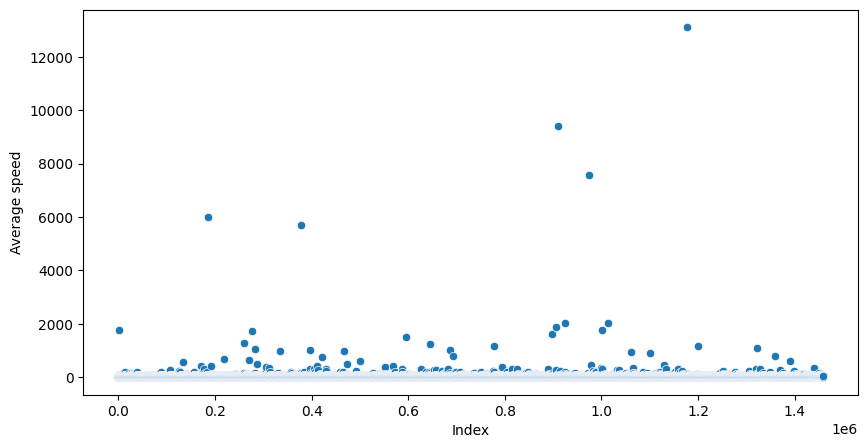

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

In [ ]:
print(
    'Количество выбросов по признаку длительности поездки:',
    df_train[df_train['trip_duration'] > 86400].shape[0]
)
print(
    'Количество выбросов по признаку скорости:',
    avg_speed[avg_speed > 150].shape[0]
)

Количество выбросов по признаку длительности поездки: 4
Количество выбросов по признаку скорости: 140


In [ ]:
mask_1 = df_train['trip_duration'] <= 86400
mask_2 = (df_train['manhattan_distance'] / df_train['trip_duration'] * 3600) <= 150
mask_3 = (df_train['manhattan_distance'] / df_train['trip_duration'] * 3600) >= 1
df_train = df_train[mask_1 & mask_2 & mask_3]

In [ ]:
df_train['geo_cluster'].value_counts().sort_values(ascending = False)

Посмотрим как выглядит распределение продолжительности поездки

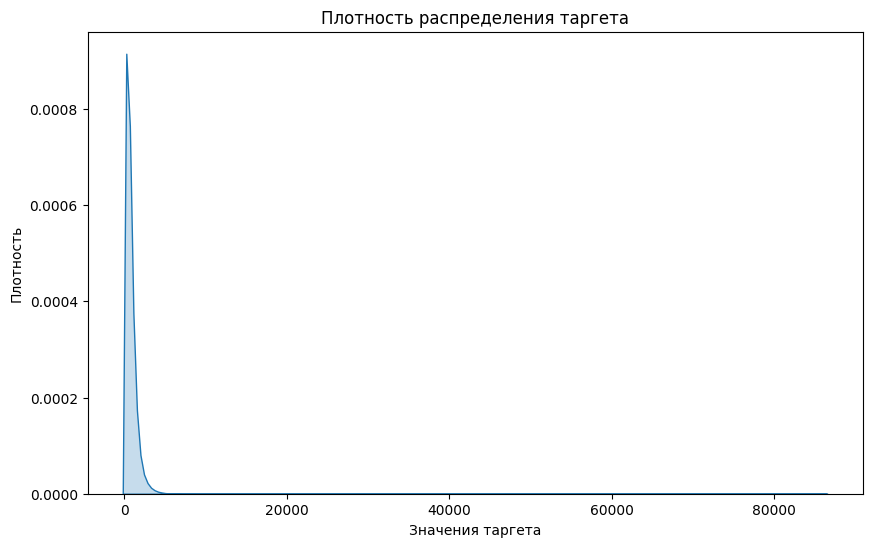

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train['trip_duration'], fill=True)
plt.title('Плотность распределения таргета')
plt.xlabel('Значения таргета')
plt.ylabel('Плотность')
plt.show()

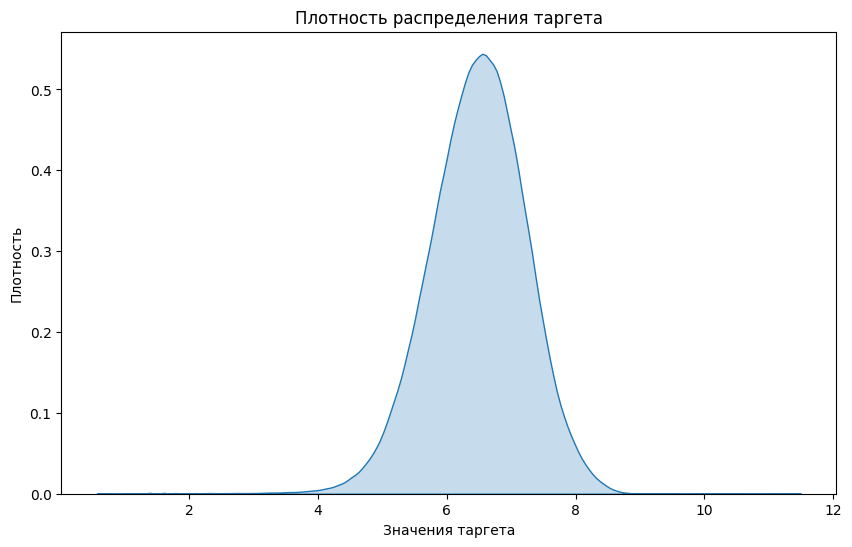

In [ ]:
df_train['trip_duration_log'] = np.log(df_train['trip_duration'] + 1)
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train['trip_duration_log'], fill=True)
plt.title('Плотность распределения таргета')
plt.xlabel('Значения таргета')
plt.ylabel('Плотность')
plt.show()

На графике видно выброс справа, необходимо его удалить

In [ ]:
print(
    'Количество выбросов по признаку длительности поездки:',
    df_train[df_train['trip_duration_log'] > 11].shape[0]
)

Количество выбросов по признаку длительности поездки: 80


In [ ]:
index = df_train['trip_duration_log'] <= 11
df_train = df_train[index]

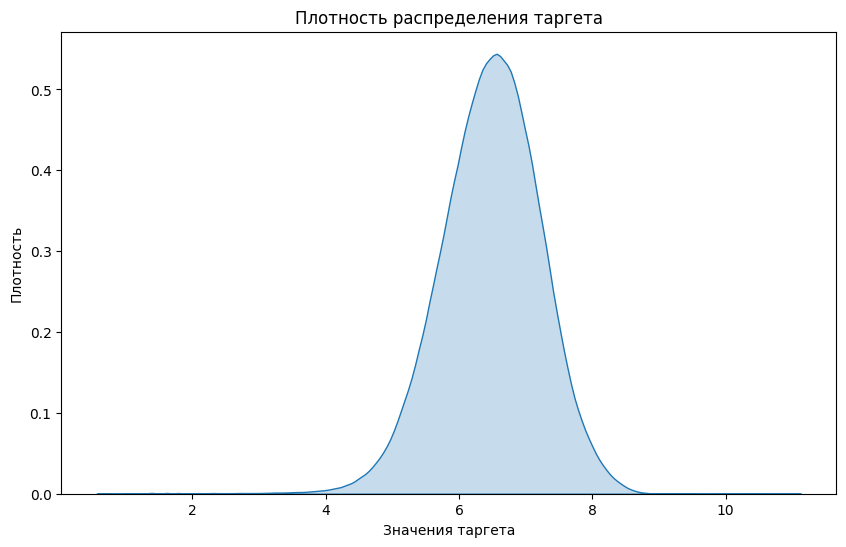

In [ ]:
df_train['trip_duration_log'] = np.log(df_train['trip_duration'] + 1)
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train['trip_duration_log'], fill=True)
plt.title('Плотность распределения таргета')
plt.xlabel('Значения таргета')
plt.ylabel('Плотность')
plt.show()

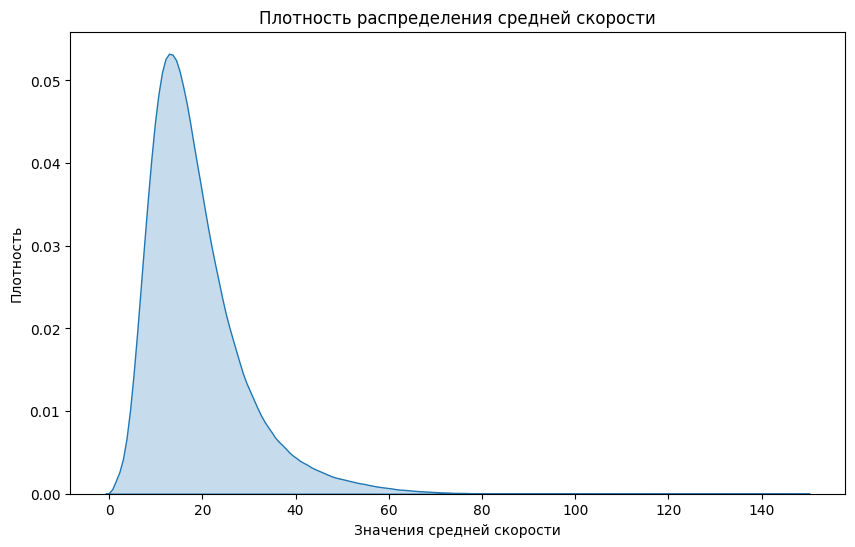

In [ ]:
avg_speed = df_train['manhattan_distance'] / df_train['trip_duration'] * 3600
plt.figure(figsize=(10, 6))
sns.kdeplot(avg_speed, fill=True)
plt.title('Плотность распределения средней скорости')
plt.xlabel('Значения средней скорости')
plt.ylabel('Плотность')
plt.show()

Визуализируем зависимость таргета от vendor_id

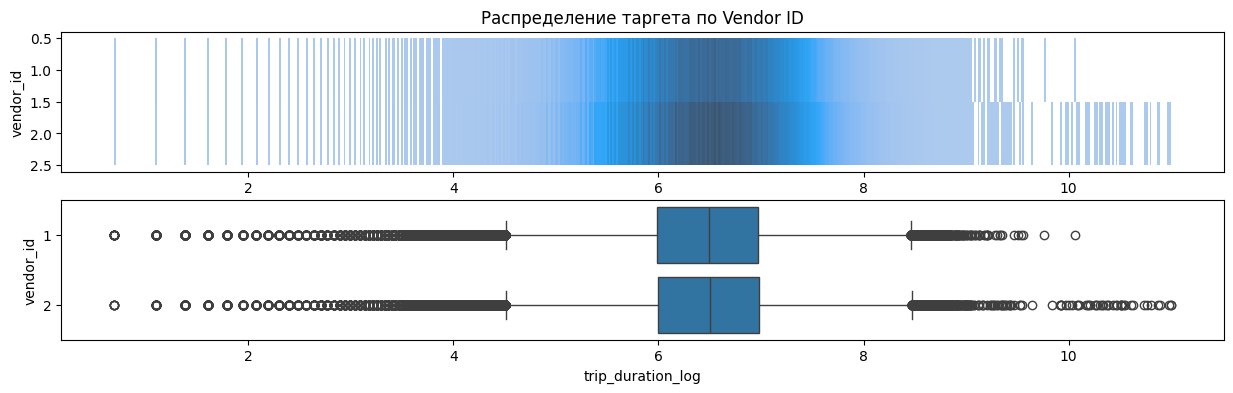

In [ ]:
df_train['vendor_id'] = df_train['vendor_id'].astype('category')

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 4))
histplot = sns.histplot(
    data = df_train,
    x = 'trip_duration_log',
    y = 'vendor_id',
    ax = axes[0]
)
histplot.set_title('Распределение таргета по Vendor ID')
boxplot = sns.boxplot(
    data = df_train,
    x = 'trip_duration_log',
    y = 'vendor_id',
    ax = axes[1]
)

Распределения практически не отличаются

Теперь визуализируем распределение таргета в зависимости от store_and_fwd_flag

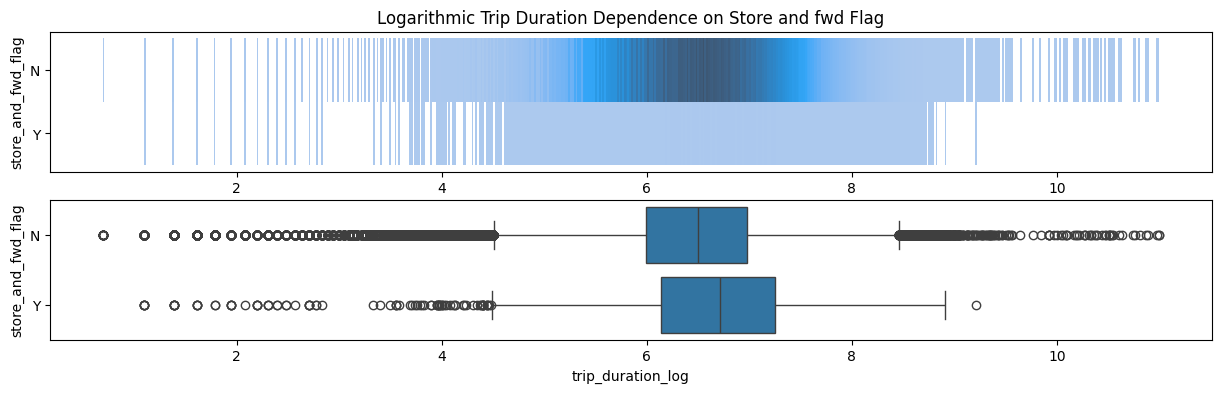

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 4))

histplot = sns.histplot(
    data = df_train,
    x = 'trip_duration_log',
    y = 'store_and_fwd_flag',
    ax = axes[0]
)
histplot.set_title('Logarithmic Trip Duration Dependence on Store and fwd Flag')
violinplot = sns.boxplot(
    data = df_train,
    x = 'trip_duration_log',
    y = 'store_and_fwd_flag',
    ax = axes[1]
);

Распределения отличаются

Создадим бинарный признак часа пик

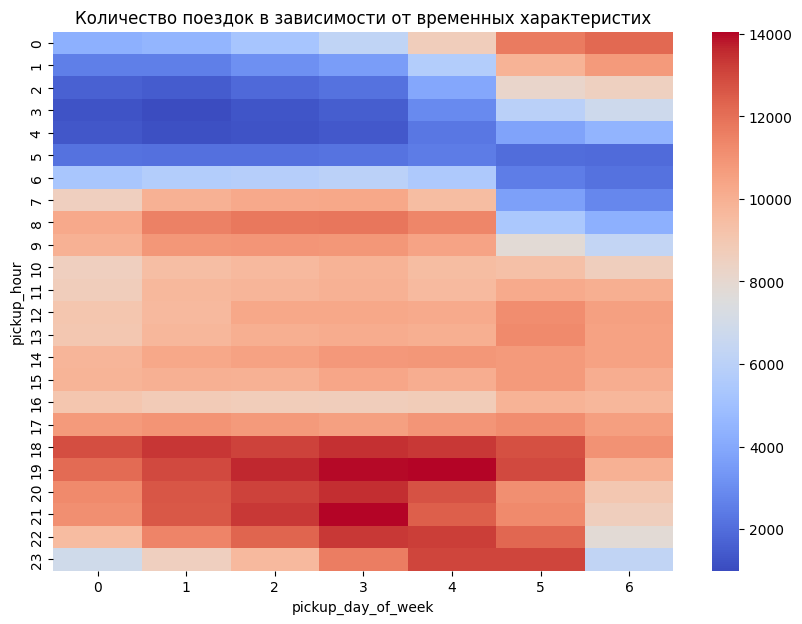

In [ ]:
pivot = df_train.pivot_table(
    values = 'trip_duration',
    index = 'pickup_hour',
    columns = 'pickup_day_of_week',
    aggfunc = 'count'
)

# визуализируем полученную таблицу
fig = plt.figure(figsize = (10, 7))
heatmap = sns.heatmap(data = pivot, cmap = 'coolwarm')
heatmap.set_title('Количество поездок в зависимости от временных характеристих');

In [ ]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,haversine_distance,direction,manhattan_distance,geo_cluster,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,1.498521,99.970196,1.735433,7,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,1.805507,-117.153768,2.430506,3,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,6.385098,-159.680165,8.203575,3,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,1.485498,-172.737700,1.661331,3,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,1.188588,179.473585,1.199457,0,6.077642


In [ ]:
def is_rush_hour(row):
    if row['pickup_day_of_week'] <= 5:
        # Утренний пик: 7:00 - 10:00, Вечерний пик: 16:00 - 19:00
        if 17 <= row['pickup_hour'] <= 19:
            return 1
    return 0

# Применяем функцию к каждому ряду данных
df_train['rush_hour'] = df_train.apply(is_rush_hour, axis=1)

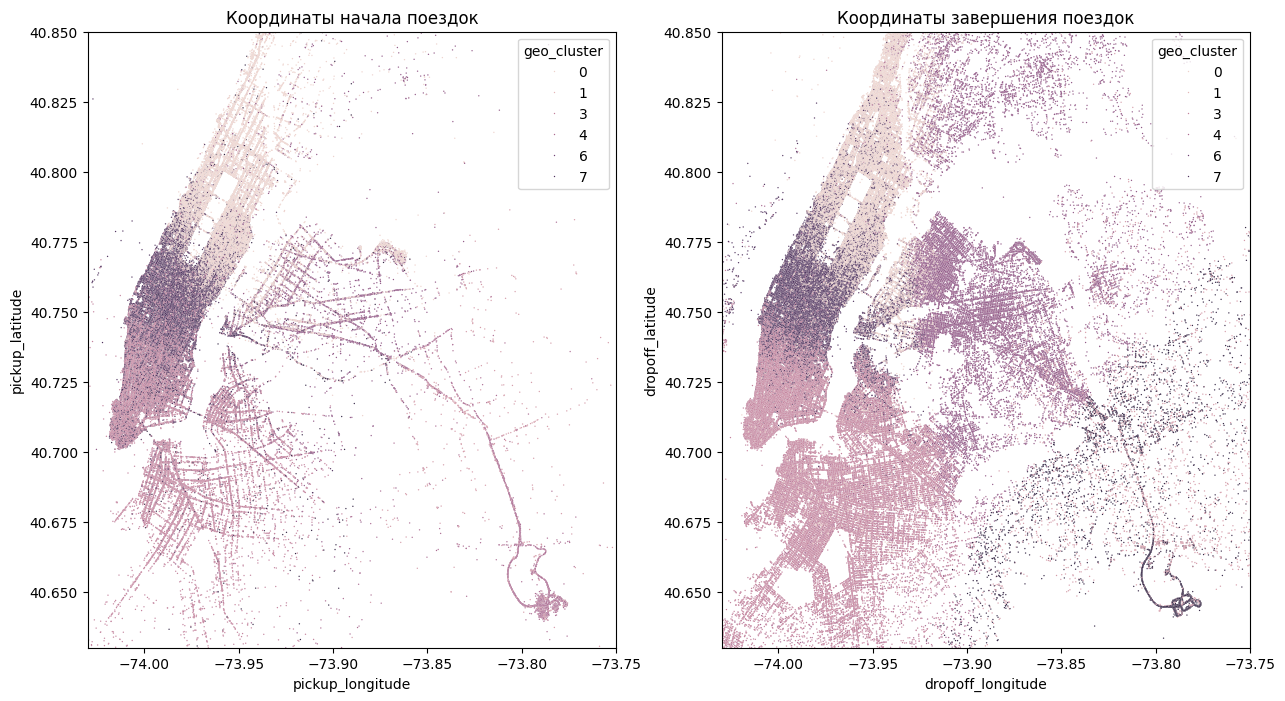

In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# строим диаграммы рассеяния
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 8))

scatter_pickup = sns.scatterplot(
    data = df_train,
    x = 'pickup_longitude',
    y = 'pickup_latitude',
    hue = 'geo_cluster',
    s = 1,
    ax = axes[0]
)
scatter_pickup.set_title('Координаты начала поездок')
scatter_pickup.set_xlim(city_long_border)
scatter_pickup.set_ylim(city_lat_border)
scatter_dropoff = sns.scatterplot(
    data = df_train,
    x = 'dropoff_longitude',
    y = 'dropoff_latitude',
    hue = 'geo_cluster',
    s = 1,
    ax = axes[1]
)
scatter_dropoff.set_title('Координаты завершения поездок')
scatter_dropoff.set_xlim(city_long_border)
scatter_dropoff.set_ylim(city_lat_border);

In [ ]:
train = df_train.copy()
train.shape

(1445915, 20)

In [ ]:
train = train.drop(['id', 'dropoff_datetime'], axis = 1)

In [ ]:
train.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,haversine_distance,direction,manhattan_distance,geo_cluster,trip_duration_log,rush_hour
0,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,1.498521,99.970196,1.735433,7,6.122493,1
1,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,1.805507,-117.153768,2.430506,3,6.498282,0
2,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,6.385098,-159.680165,8.203575,3,7.661527,0
3,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,1.485498,-172.737700,1.661331,3,6.063785,1
4,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,1.188588,179.473585,1.199457,0,6.077642,0


In [ ]:
drop_columns = ['pickup_datetime', 'pickup_date']
train = train.drop(drop_columns, axis=1)

In [ ]:
train['vendor_id'] = train['vendor_id'].apply(
    lambda x: 0 if x == 1 else 1
).astype('int')

# кодируем признак store_and_fwd_flag
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].apply(
    lambda x: 0 if x == 'N' else 1
)

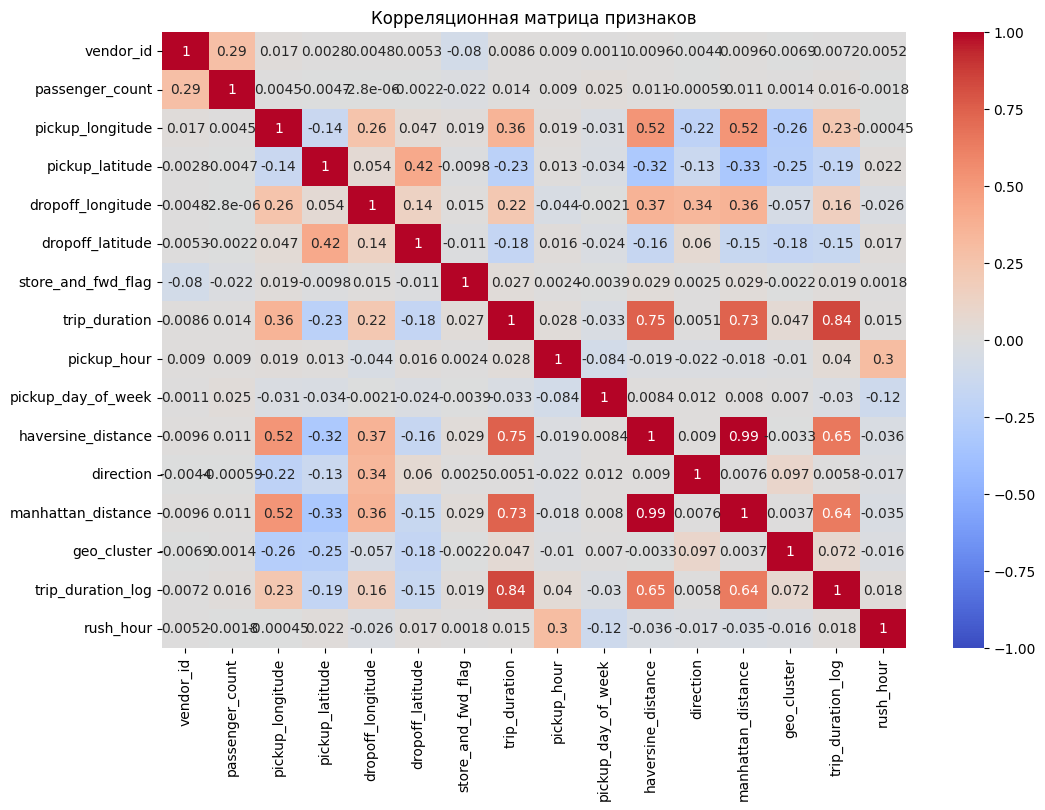

In [ ]:
# Вычисляем корреляционную матрицу
correlation_matrix = train.corr()

# Построение тепловой карты
plt.figure(figsize=(12, 8))  # Устанавливаем размер графика
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица признаков')
plt.show()


In [ ]:
one_hot_encoder = preprocessing.OneHotEncoder(drop = 'first')

# колонки к преобразованию
columns_to_change = ['pickup_day_of_week', 'geo_cluster']

# 'учим' кодировщик и сразу кодируем данные
data_onehot = one_hot_encoder.fit_transform(
    train[columns_to_change]
).toarray() # результат переводим в массив

# получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()

# составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns = column_names)

print('Количество новых бинарных столбцов:', data_onehot.shape[1])

Количество новых бинарных столбцов: 12


In [ ]:
train = pd.concat(
    [train.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot],
    axis=1
)
print('Shape of data: {}'.format(train.shape))

Shape of data: (1445915, 26)


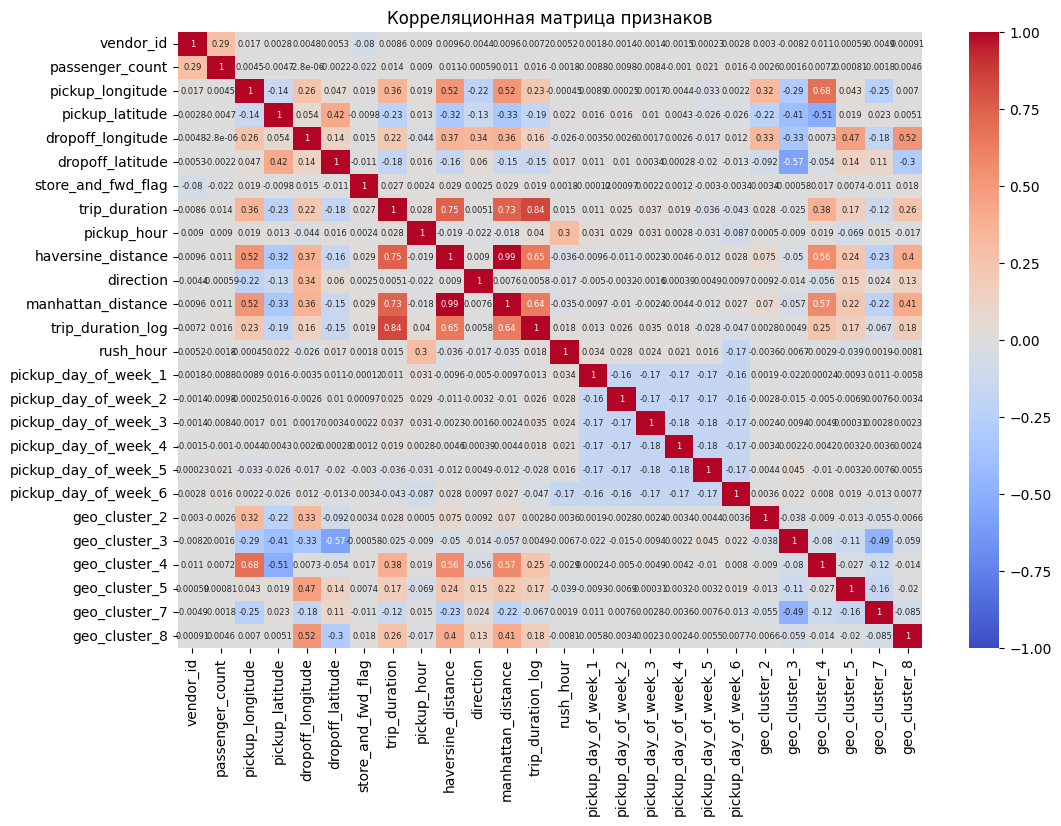

In [ ]:
# Вычисляем корреляционную матрицу
correlation_matrix = train.corr()

# Построение тепловой карты
plt.figure(figsize=(12, 8))  # Устанавливаем размер графика
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 6})
plt.title('Корреляционная матрица признаков')
plt.show()


In [ ]:
X = train.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train['trip_duration']
y_log = train['trip_duration_log']

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X, y,
    test_size=0.33,
    random_state=40
)

In [ ]:
selector = feature_selection.SelectKBest(
    score_func = feature_selection.f_regression,
    k = 27
)
selector.fit(X_train, y_train)

# оставляем только полученные 25 признаков
best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]
print('Признаки, которые вошли в список отобранных:\n', best_features)

Признаки, которые вошли в список отобранных:
 ['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'haversine_distance' 'direction' 'manhattan_distance' 'rush_hour'
 'pickup_day_of_week_1' 'pickup_day_of_week_2' 'pickup_day_of_week_3'
 'pickup_day_of_week_4' 'pickup_day_of_week_5' 'pickup_day_of_week_6'
 'geo_cluster_2' 'geo_cluster_3' 'geo_cluster_4' 'geo_cluster_5'
 'geo_cluster_7' 'geo_cluster_8']


In [ ]:
mm_scaler = preprocessing.MinMaxScaler()

# преобразовываем данные
X_train = mm_scaler.fit_transform(X_train)
X_valid = mm_scaler.transform(X_valid)

print(
    'Среднее арифметическое для первого предиктора из валидационной выборки:',
    np.round(np.mean(X_valid[:, 0]), 2)
)

# составляем DataFrame из массивов
X_train = pd.DataFrame(X_train, columns = best_features)
X_valid = pd.DataFrame(X_valid, columns = best_features)

Среднее арифметическое для первого предиктора из валидационной выборки: 0.53


In [ ]:
lr_model = linear_model.LinearRegression()

# обучаем модель - ищем параметры МНК
#lr_model.fit(X_train, y_train_log)
lr_model.fit(X_train, y_train)

# делаем предсказания
y_train_pred = lr_model.predict(X_train)
y_valid_pred = (lr_model.predict(X_valid))
#print(y_train_pred.max())
#print(y_log.max())
#print(np.exp(y_train_pred)[:15])
#print(y[:15])
# рассчитываем RMSLE
print(
    'RMSE на тренировочной выборке:',
    round(np.sqrt(metrics.mean_squared_error((y_train), (y_train_pred))), 2)
)
print(
    'RMSE на валидационной выборке:',
    round(np.sqrt(metrics.mean_squared_error(y_valid, y_valid_pred)), 2)
)
weights = lr_model.coef_
print(weights)

RMSE на тренировочной выборке: 441.69
RMSE на валидационной выборке: 439.59
[ 8.99730827e-01  2.10957069e+01  7.67453012e+02  7.85396273e+02
 -3.50595364e+02 -3.13946581e+03  4.47973625e+01  6.69240767e+01
  4.08936635e+04  5.16128196e+01 -1.29020132e+04  5.21955042e+01
  7.21307865e+01  9.67719684e+01  1.04499889e+02  8.03260983e+01
  3.56401287e-01 -5.46545863e+01 -4.61884757e+02 -2.55428295e+01
 -3.79187439e+02 -6.51167454e+01  8.19211405e+01 -6.07207697e+02]


In [ ]:
test = pd.read_csv('data/test.csv')
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N
